# SARIMAX

In [2]:
import sys
import os
sys.path.append('../')  # Go up to src/ directory

import numpy as np
from dataset import load_and_preprocess_sarimax_data
from models import SARIMAX_model
import matplotlib.pyplot as plt

# Data Setup

In [3]:
df = load_and_preprocess_sarimax_data('../../data/energy_data.csv')

target = 'spot'
exog_vars = ['wind_forecast_dah_mw', 'consumption_forecast_dah_mw', 
             'temp_forecast_dah_celcius', 'temp_norm_celcius',
             'heating_demand_interaction', 'temp_deviation', 'spot_lag1']

# Train/test split (80/20)
split_idx = int(len(df) * 0.8)
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()

y_train = train_data[target].values
X_train = train_data[exog_vars].values

y_test = test_data[target].values
X_test = test_data[exog_vars].values

# SARIMAX Load or search

In [ ]:
model = SARIMAX_model()
try:
    model.load("SARIMAX_model.pkl")
except Exception as e:
    model = SARIMAX_model().auto_train(y_train, X_train, max_p=5, max_q=5)
    model.save("SARIMAX_model.pkl")

# SARIMAX Predictions and plot

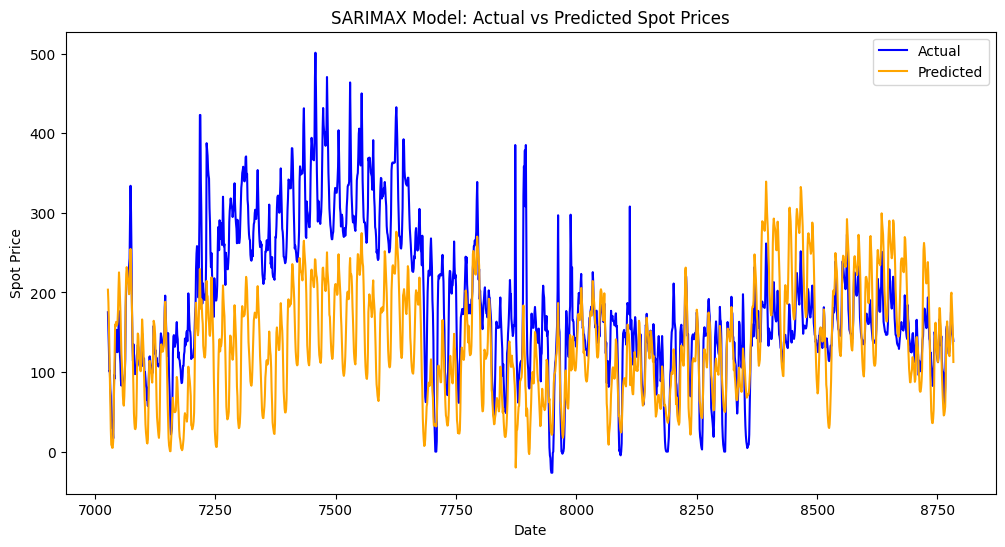

In [6]:
predictions = model.predict(y_train=y_train, X_train=X_train, X_test=X_test, steps=len(y_test))


plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title('SARIMAX Model: Actual vs Predicted Spot Prices')
plt.legend()
plt.show()

# SARIMAX ODG/ECI

In [7]:
from OGD import OGD_Predictor

actuals = y_test

ogd = OGD_Predictor(alpha=0.1, eta=5.0, q_init=50)

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [153.96, 252.96], pred=203.46, true=175.11, covered=True, q=49.50
t=100: [39.74, 148.74], pred=94.24, true=110.15, covered=True, q=54.50
t=200: [10.74, 229.74], pred=120.24, true=192.67, covered=True, q=109.50
t=300: [-111.44, 317.56], pred=103.06, true=253.22, covered=True, q=214.50
t=400: [49.35, 408.35], pred=228.85, true=354.17, covered=True, q=179.50
t=500: [17.01, 366.01], pred=191.51, true=334.96, covered=True, q=174.50
t=600: [101.40, 440.40], pred=270.90, true=415.45, covered=True, q=169.50
t=700: [-82.89, 226.11], pred=71.61, true=100.16, covered=True, q=154.50
t=800: [-68.32, 160.68], pred=46.18, true=52.50, covered=True, q=114.50
t=900: [-66.35, 162.65], pred=48.15, true=120.91, covered=True, q=114.50
t=1000: [53.54, 252.54], pred=153.04, true=167.83, covered=True, q=99.50
t=1100: [26.92, 175.92], pred=101.42, true=118.88, covered=True, q=74.50
t=1200: [171.68, 290.68], pred=231.18, true=219.97, covered=True, q=59.50
t=1300: [57.73, 146.73], pred=102.23, true=115.66, c

In [36]:
from OGD import ECI_Predictor

actuals = y_test

eci = ECI_Predictor(alpha=0.1, eta=6.0, q_init=100, c=1.0, version='basic', eq_function='gaussian')

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = eci.get_interval(y_pred)
    covered = eci.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci.q
        threshold = eci.q
        
    if t % 100 == 0:
        lower, upper = eci.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci.q:.2f}")

print("\n ")
print(f"Coverage Rate: {eci.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {eci.q:.2f}")
print(f"Average Width: {np.mean(eci.threshold_history)*2:.2f}")

misses = sum(1 for c in eci.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci.coverage_history)}")

t=0: [107.75, 299.16], pred=203.46, true=175.11, covered=True, q=95.70
t=100: [80.94, 107.55], pred=94.24, true=110.15, covered=True, q=13.30
t=200: [25.45, 215.04], pred=120.24, true=192.67, covered=True, q=94.79
t=300: [-88.54, 294.66], pred=103.06, true=253.22, covered=True, q=191.60
t=400: [82.95, 374.75], pred=228.85, true=354.17, covered=True, q=145.90
t=500: [25.22, 357.79], pred=191.51, true=334.96, covered=True, q=166.28
t=600: [109.27, 432.52], pred=270.90, true=415.45, covered=True, q=161.63
t=700: [-44.08, 187.30], pred=71.61, true=100.16, covered=True, q=115.69
t=800: [14.85, 77.51], pred=46.18, true=52.50, covered=True, q=31.33
t=900: [-29.44, 125.74], pred=48.15, true=120.91, covered=True, q=77.59
t=1000: [122.82, 183.25], pred=153.04, true=167.83, covered=True, q=30.22
t=1100: [59.43, 143.41], pred=101.42, true=118.88, covered=True, q=41.99
t=1200: [212.46, 249.91], pred=231.18, true=219.97, covered=True, q=18.73
t=1300: [82.48, 121.97], pred=102.23, true=115.66, covere